<a href="https://colab.research.google.com/github/adheeb4/7PAM2002_0509_2023_Final_Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.5-py2.py3-none-any.whl size=265646558 sha256=449ff0c9e9d93a14edb7816b573a5fe1c5ad251f4f4e266de854aa2f3a13cf41
  Stored in directory: /root/.cache/pip/wheels/1a/46/4f/9b366522399306d7849672d58aefb44c9b73378d710bde2853
Successfully built h2o


In [1]:
import pandas as pd
from google.colab import files
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from scipy.stats import skew, kurtosis
from h2o.automl import H2OAutoML
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Data/'

fundamentals_df = pd.read_csv(file_path + 'fundamentals.csv')
prices_df = pd.read_csv(file_path + 'prices.csv')
prices_split_adjusted_df = pd.read_csv(file_path + 'prices-split-adjusted.csv')
securities_df = pd.read_csv(file_path + 'securities.csv')


prices_df['date'] = pd.to_datetime(prices_df['date'], format='mixed')

# Format the 'date' column to 'YYYY-MM-DD'
prices_df['date'] = prices_df['date'].dt.strftime('%Y-%m-%d')



print("Fundamentals Data")
print(fundamentals_df.head())

print("\nPrices Data")
print(prices_df.head())

print("\nPrices Split Adjusted Data")
print(prices_split_adjusted_df.head())

print("\nSecurities Data")
print(securities_df.head())

Fundamentals Data
   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2    

In [5]:
# Summary statistics for numerical columns
print(fundamentals_df.describe())

# Count unique values for categorical columns
print(fundamentals_df['Ticker Symbol'].value_counts())
print(securities_df['GICS Sector'].value_counts())


        Unnamed: 0  Accounts Payable  Accounts Receivable  \
count  1781.000000      1.781000e+03         1.781000e+03   
mean    890.000000      4.673418e+09        -6.353484e+07   
std     514.274732      1.406047e+10         7.562794e+08   
min       0.000000      0.000000e+00        -6.452000e+09   
25%     445.000000      5.160000e+08        -1.040000e+08   
50%     890.000000      1.334000e+09        -1.830000e+07   
75%    1335.000000      3.246000e+09         7.816000e+06   
max    1780.000000      2.069390e+11         2.266400e+10   

       Add'l income/expense items  After Tax ROE  Capital Expenditures  \
count                1.781000e+03    1781.000000          1.781000e+03   
mean                 6.908940e+07      43.601348         -1.251925e+09   
std                  6.848143e+08     233.924028          2.979963e+09   
min                 -6.768000e+09       0.000000         -3.798500e+10   
25%                 -2.638000e+06      10.000000         -1.151200e+09   
50%   

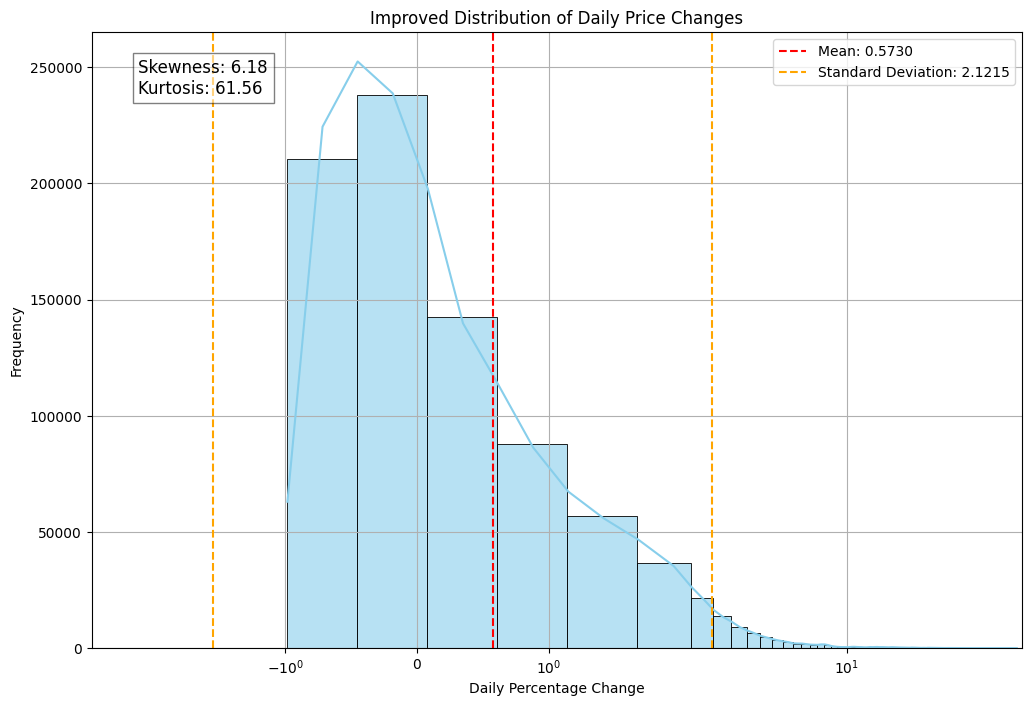

In [6]:
prices_data_cleaned = prices_split_adjusted_df.copy()
prices_data_cleaned['price_change'] = prices_data_cleaned['close'].pct_change()

# Use bfill() to fill NaN values after percentage change calculation
prices_data_cleaned['price_change'] = prices_data_cleaned['price_change'].bfill()

# Calculate skewness and kurtosis
price_change_skewness = skew(prices_data_cleaned['price_change'])
price_change_kurtosis = kurtosis(prices_data_cleaned['price_change'])

# Improved Histogram for stock price change distribution
plt.figure(figsize=(12, 8))
sns.histplot(prices_data_cleaned['price_change'], bins=100, kde=True, color='skyblue', alpha=0.6)

# Add vertical lines for mean and standard deviation
mean_price_change = prices_data_cleaned['price_change'].mean()
std_price_change = prices_data_cleaned['price_change'].std()

plt.axvline(mean_price_change, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_price_change:.4f}')
plt.axvline(mean_price_change + std_price_change, color='orange', linestyle='--', linewidth=1.5, label=f'Standard Deviation: {std_price_change:.4f}')
plt.axvline(mean_price_change - std_price_change, color='orange', linestyle='--', linewidth=1.5)

# Set a logarithmic scale for the x-axis if there is a wide range of values
plt.xscale('symlog')

# Add labels, title, and legend
plt.title('Improved Distribution of Daily Price Changes')
plt.xlabel('Daily Percentage Change')
plt.ylabel('Frequency')
plt.legend()

# Display skewness and kurtosis on the plot
plt.text(0.05, 0.9, f'Skewness: {price_change_skewness:.2f}\nKurtosis: {price_change_kurtosis:.2f}',
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True)
plt.show()


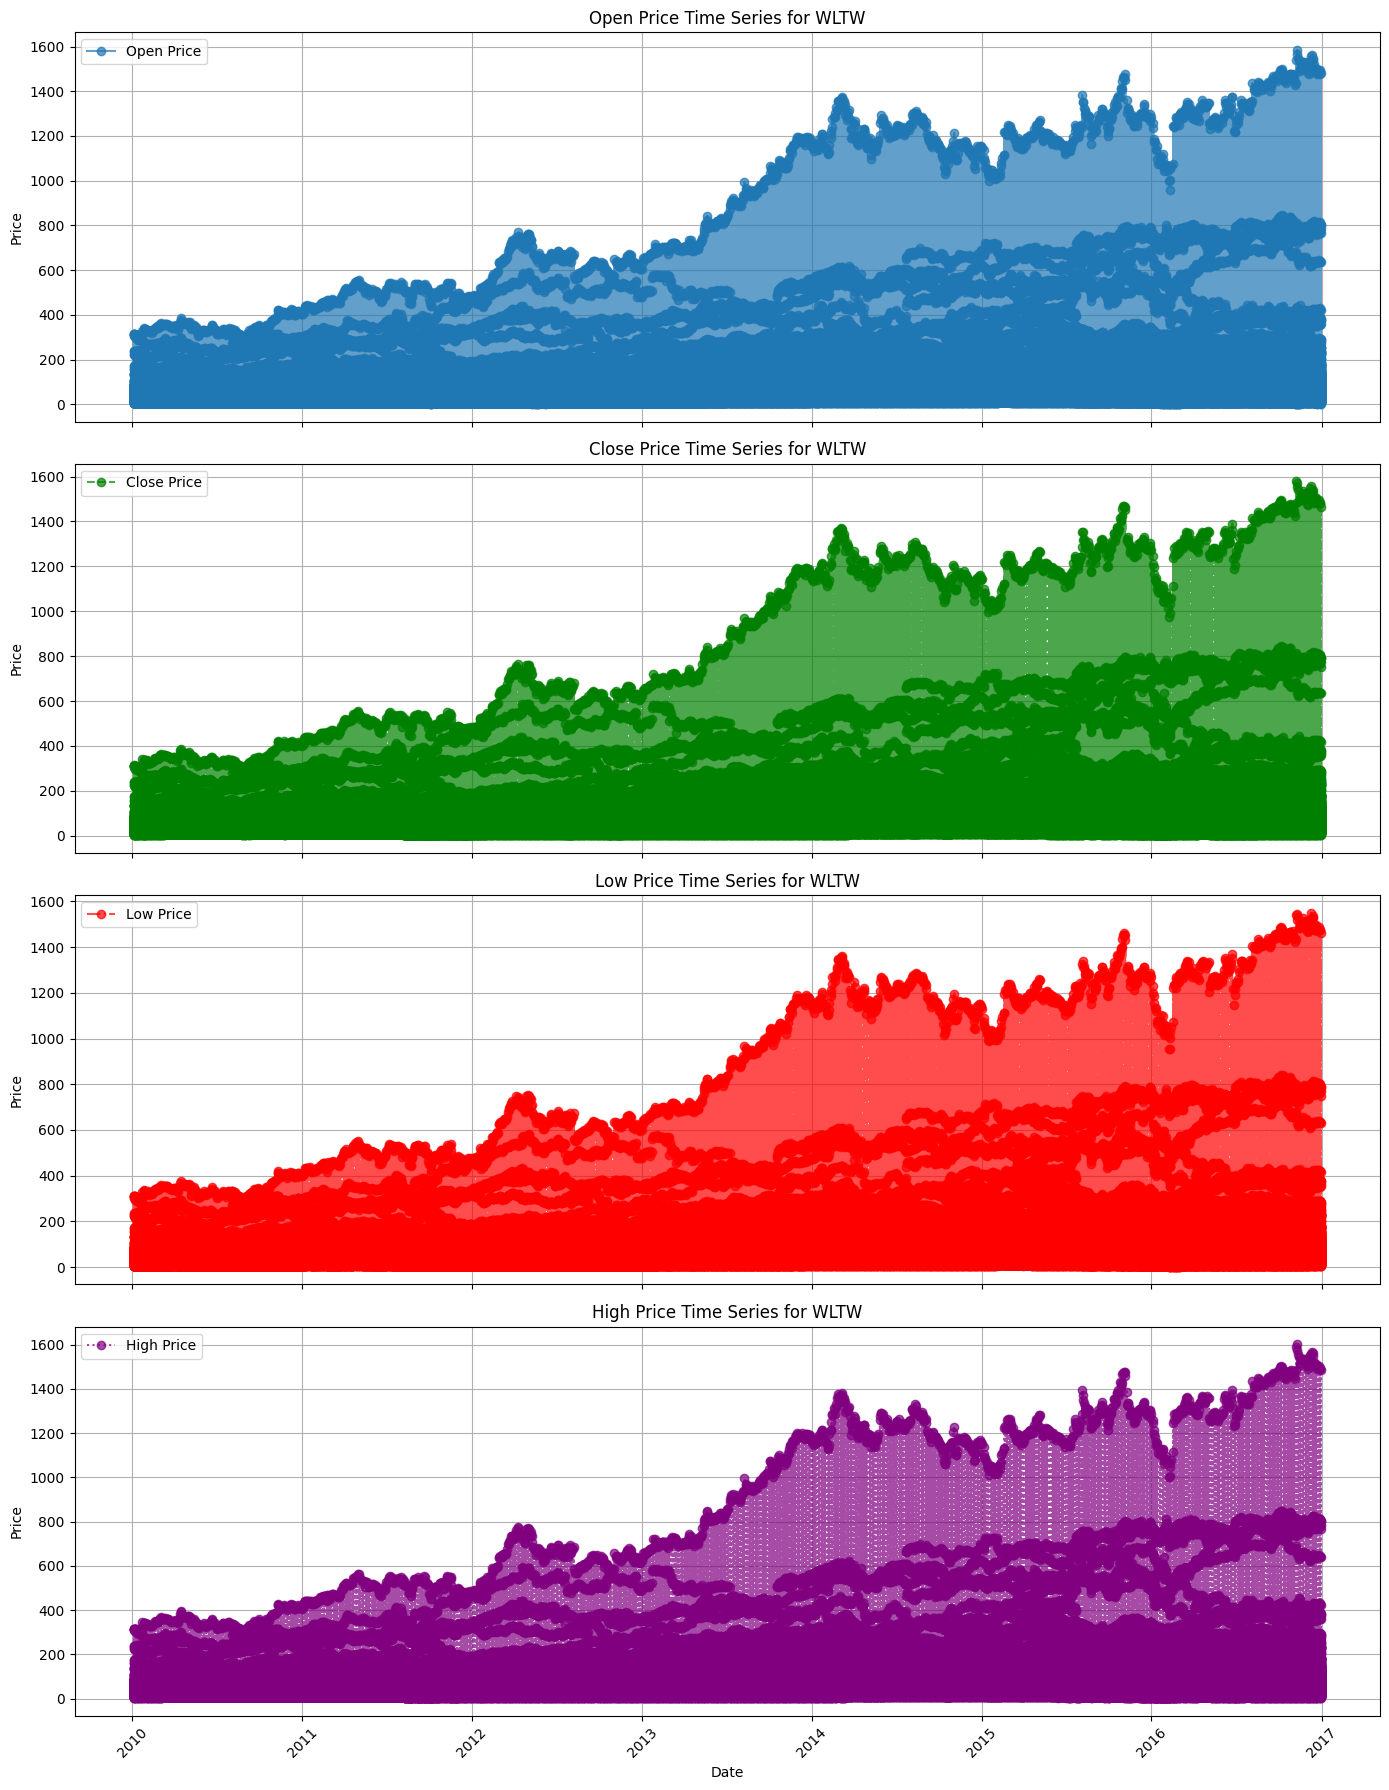

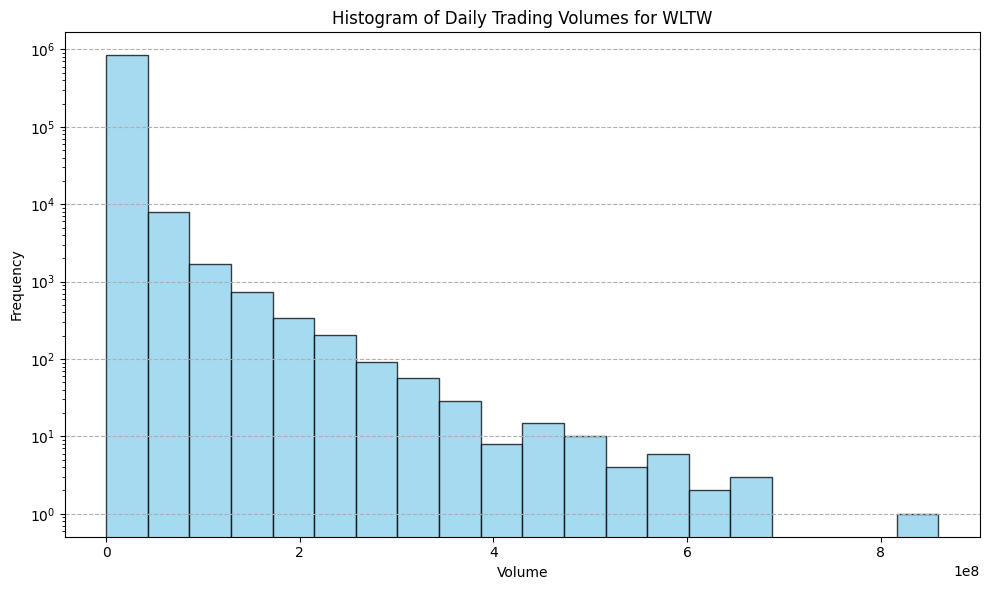

In [7]:
prices_data_cleaned['date'] = pd.to_datetime(prices_data_cleaned['date'])
#visualization with separate subplots for each price type
fig, axs = plt.subplots(4, 1, figsize=(14, 18), sharex=True)

# Open Price
axs[0].plot(prices_data_cleaned['date'], prices_data_cleaned['open'], label='Open Price', linestyle='-', marker='o', alpha=0.7)
axs[0].set_title('Open Price Time Series for WLTW')
axs[0].set_ylabel('Price')
axs[0].legend(loc='upper left')
axs[0].grid(True)

# Close Price
axs[1].plot(prices_data_cleaned['date'], prices_data_cleaned['close'], label='Close Price', linestyle='--', marker='o', alpha=0.7, color='green')
axs[1].set_title('Close Price Time Series for WLTW')
axs[1].set_ylabel('Price')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Low Price
axs[2].plot(prices_data_cleaned['date'], prices_data_cleaned['low'], label='Low Price', linestyle='-.', marker='o', alpha=0.7, color='red')
axs[2].set_title('Low Price Time Series for WLTW')
axs[2].set_ylabel('Price')
axs[2].legend(loc='upper left')
axs[2].grid(True)

# High Price
axs[3].plot(prices_data_cleaned['date'], prices_data_cleaned['high'], label='High Price', linestyle=':', marker='o', alpha=0.7, color='purple')
axs[3].set_title('High Price Time Series for WLTW')
axs[3].set_ylabel('Price')
axs[3].legend(loc='upper left')
axs[3].grid(True)

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Histogram of daily trading volumes
plt.figure(figsize=(10, 6))
plt.hist(prices_data_cleaned['volume'], bins=20, color='skyblue', edgecolor='black', alpha=0.75)
plt.title('Histogram of Daily Trading Volumes for WLTW')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.yscale('log')  # Logarithmic scale to handle outliers
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()



In [ ]:
def plotCorrelationMatrix(df, graphWidth, filename='DataFrame'):
    # Ensure the DataFrame only contains numeric columns
    df = df.select_dtypes(include=[float, int])
    df = df.dropna(axis='columns')  # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns with more than 1 unique value

    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return

    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)

    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)

    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

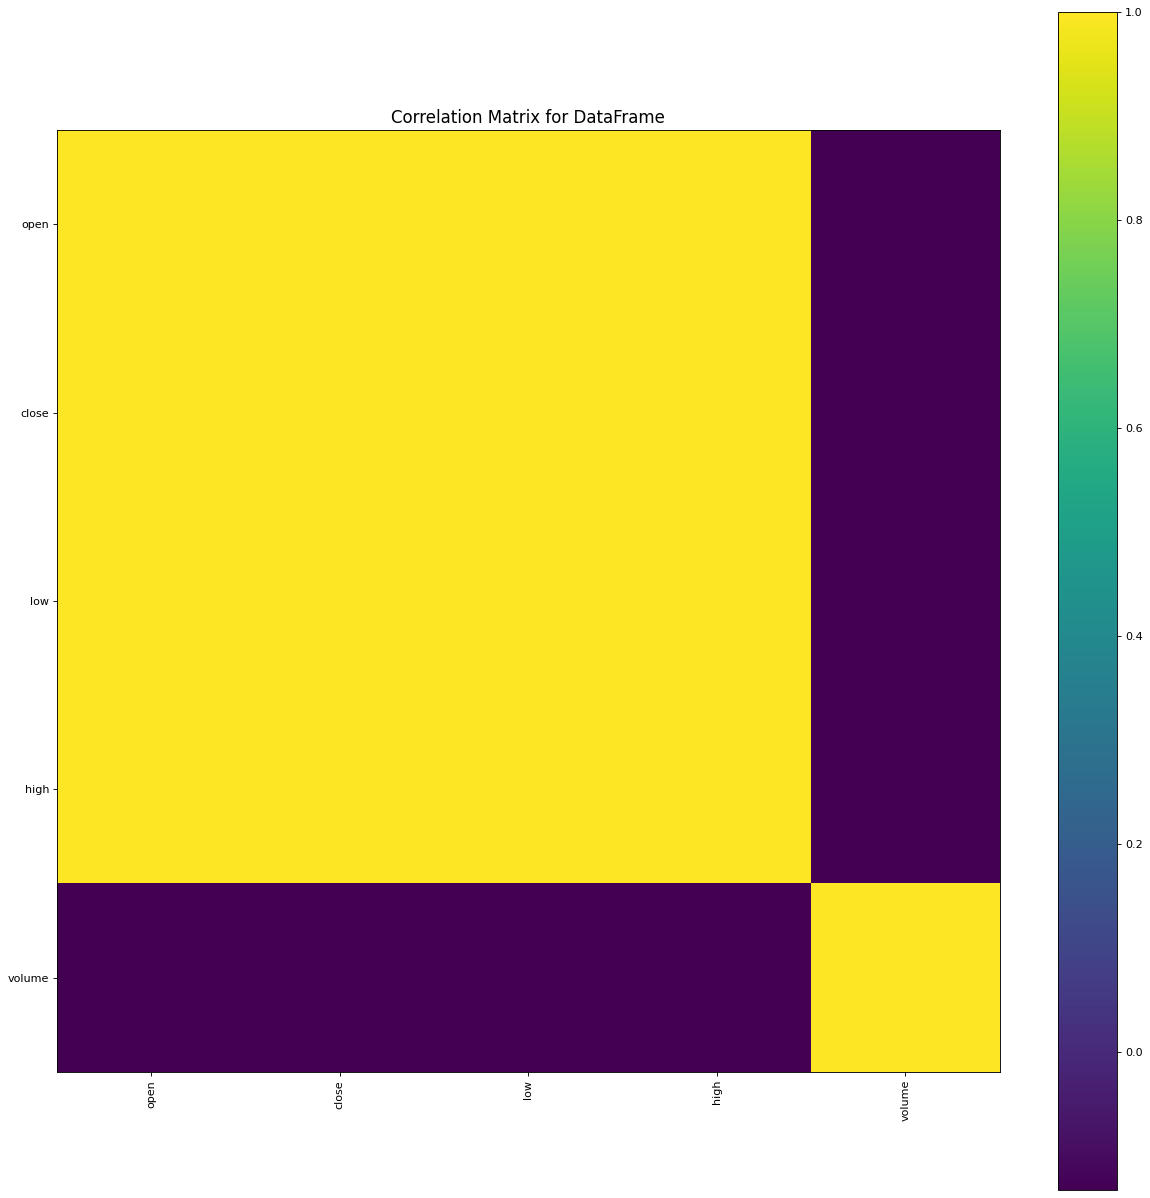

In [11]:
plotCorrelationMatrix(prices_split_adjusted_df, 19)

In [4]:
def extract_date_features(df, date_col='date', date_format='%Y-%m-%d'):
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors='coerce')
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['day_of_week'] = df[date_col].dt.dayofweek
    return df


In [5]:
df = extract_date_features(prices_split_adjusted_df)

In [6]:
df['prev_close'] = df.groupby('symbol')['close'].shift(1)
df['close_rolling_mean_7'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).mean())
df['close_rolling_std_7'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).std())
df['daily_return'] = df.groupby('symbol')['close'].pct_change()

In [7]:
print(df)

             date symbol        open       close         low        high  \
0      2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1      2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2      2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3      2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4      2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   
...           ...    ...         ...         ...         ...         ...   
851259 2016-12-30    ZBH  103.309998  103.199997  102.849998  103.930000   
851260 2016-12-30   ZION   43.070000   43.040001   42.689999   43.310001   
851261 2016-12-30    ZTS   53.639999   53.529999   53.270000   53.740002   
851262 2016-12-30    AIV   44.730000   45.450001   44.410000   45.590000   
851263 2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   

           volume  year  month  day  day_of_week  prev_close  \
0       2163600.0  2016

In [8]:
combined_df = df

In [9]:
combined_df = combined_df.fillna(method='bfill')

<ipython-input-9-4a1070dfbd1e>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='bfill')


In [ ]:
plotCorrelationMatrix(combined_df, 30)

In [21]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvtwe5i10
  JVM stdout: /tmp/tmpvtwe5i10/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvtwe5i10/h2o_unknownUser_started_from_python.err


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_unknownUser_edxpzn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12.75 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [13]:
symbols_to_select = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
results = {}

In [23]:
def train_and_evaluate_model(symbol, combined_df):
    filtered_df = combined_df[combined_df['symbol'] == symbol].drop(columns=['symbol'])

    X = filtered_df.drop(['close'], axis=1)
    y = filtered_df['close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
    test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

    aml = H2OAutoML(max_runtime_secs=300, seed=1)
    aml.train(x=list(X_train.columns), y='close', training_frame=train_h2o, leaderboard_frame=test_h2o)

    lb = aml.leaderboard.as_data_frame(use_multi_thread=True)
    best_model = aml.leader

    predictions = best_model.predict(test_h2o)

    predictions_df = predictions.as_data_frame()

    rmse = np.sqrt(mean_squared_error(test_h2o['close'].as_data_frame(), predictions_df['predict']))

    plot_model_performance(test_h2o, predictions_df, X_test.columns, 'date')

    return {
        'leaderboard': lb,
        'best_model': best_model,
        'predictions': predictions_df,
        'rmse': rmse
    }

def plot_model_performance(test_h2o, predictions_df, feature_columns, time_column='date'):
    time_series = test_h2o[time_column].as_data_frame()
    actual_values = test_h2o['close'].as_data_frame()

    time_series[time_column] = pd.to_datetime(time_series[time_column], unit='ms')

    df = pd.concat([time_series, actual_values, predictions_df['predict']], axis=1)
    df.columns = [time_column, 'Actual', 'Predicted']

    df = df.sort_values(by=time_column)

    plt.figure(figsize=(14, 8))
    plt.plot(df[time_column], df['Actual'], label='Actual')
    plt.plot(df[time_column], df['Predicted'], label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted over Time')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_unknownUser_edxpzn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12.75 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Processing symbol: AAPL
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow a

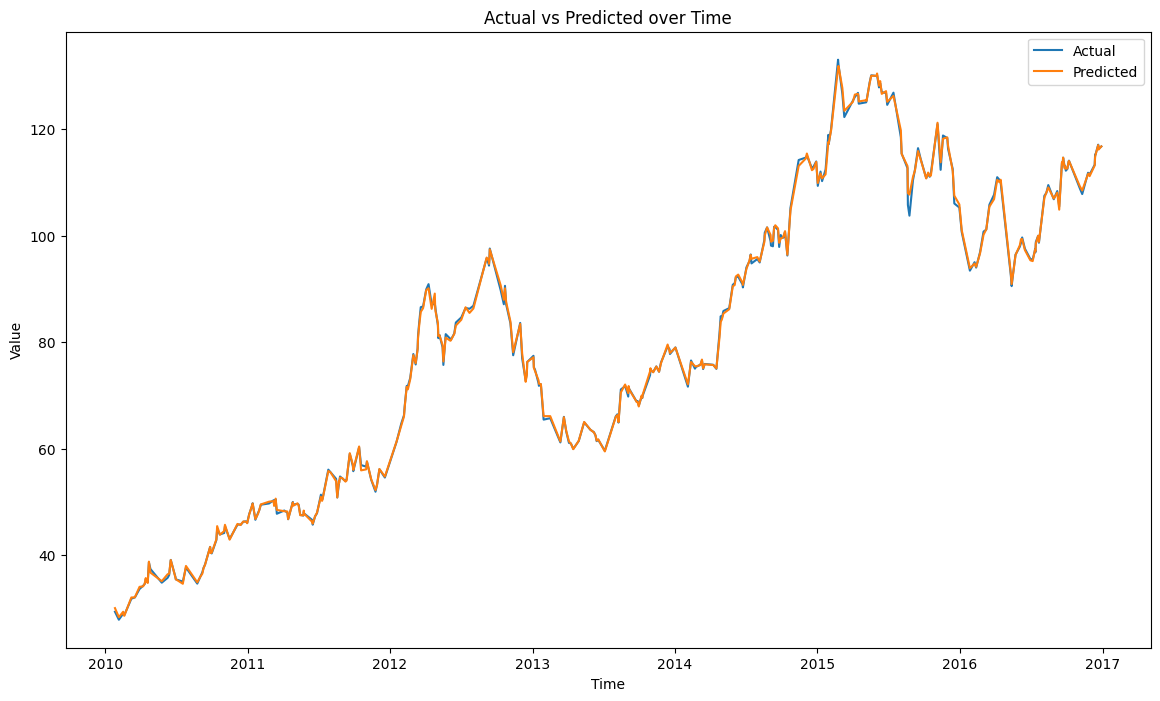

Leaderboard for AAPL:
                                            model_id      rmse       mse  \
0  StackedEnsemble_BestOfFamily_4_AutoML_1_202409...  0.482227  0.232543   
1  StackedEnsemble_AllModels_2_AutoML_1_20240905_...  0.482369  0.232680   
2  StackedEnsemble_AllModels_1_AutoML_1_20240905_...  0.482379  0.232689   
3  StackedEnsemble_BestOfFamily_2_AutoML_1_202409...  0.482398  0.232708   
4  StackedEnsemble_BestOfFamily_3_AutoML_1_202409...  0.482735  0.233034   

        mae     rmsle  mean_residual_deviance  
0  0.318615  0.005752                0.232543  
1  0.318805  0.005753                0.232680  
2  0.318838  0.005753                0.232689  
3  0.318912  0.005755                0.232708  
4  0.318804  0.005755                0.233034  
RMSE for AAPL: 0.4822271570659028

Processing symbol: GOOGL
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████████████████████████████████

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow a

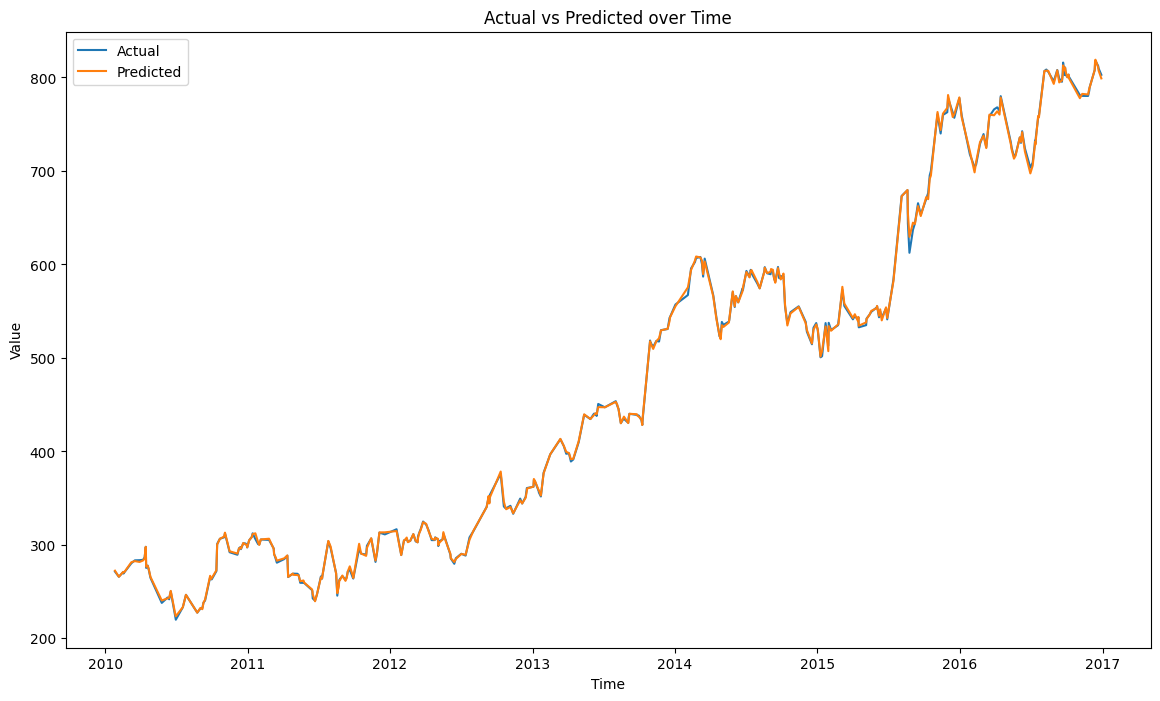

Leaderboard for GOOGL:
                                            model_id      rmse       mse  \
0  StackedEnsemble_BestOfFamily_4_AutoML_2_202409...  2.313656  5.353002   
1        GBM_grid_1_AutoML_2_20240905_93936_model_63  2.340298  5.476994   
2        GBM_grid_1_AutoML_2_20240905_93936_model_37  2.363205  5.584736   
3        GBM_grid_1_AutoML_2_20240905_93936_model_59  2.377258  5.651355   
4        GBM_grid_1_AutoML_2_20240905_93936_model_42  2.378765  5.658525   

        mae     rmsle  mean_residual_deviance  
0  1.569309  0.004813                5.353002  
1  1.578971  0.004817                5.476994  
2  1.625077  0.004955                5.584736  
3  1.658294  0.005324                5.651355  
4  1.614248  0.004761                5.658525  
RMSE for GOOGL: 2.313655300007581

Processing symbol: MSFT
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████████████████████████████████

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow a

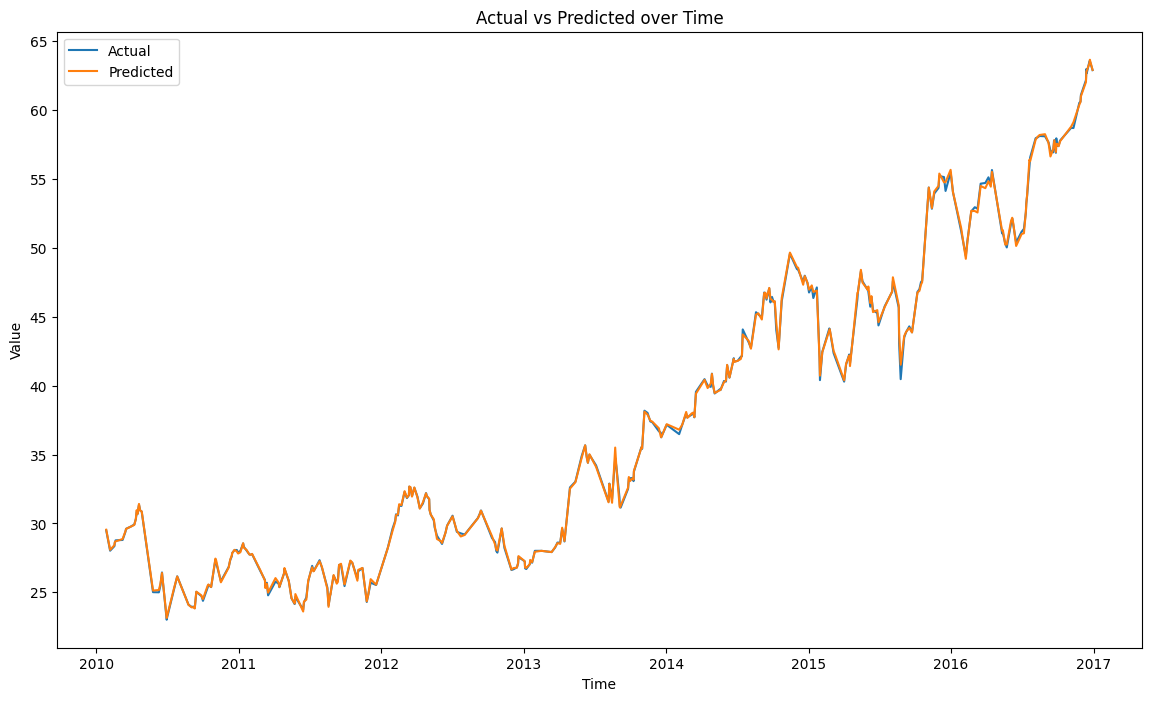

Leaderboard for MSFT:
                                            model_id      rmse       mse  \
0  StackedEnsemble_BestOfFamily_2_AutoML_3_202409...  0.162107  0.026279   
1  StackedEnsemble_AllModels_1_AutoML_3_20240905_...  0.162138  0.026289   
2  StackedEnsemble_BestOfFamily_1_AutoML_3_202409...  0.162272  0.026332   
3  StackedEnsemble_AllModels_2_AutoML_3_20240905_...  0.162326  0.026350   
4  StackedEnsemble_BestOfFamily_4_AutoML_3_202409...  0.162333  0.026352   

        mae     rmsle  mean_residual_deviance  
0  0.106597  0.003962                0.026279  
1  0.106595  0.003963                0.026289  
2  0.107188  0.003978                0.026332  
3  0.107082  0.003964                0.026350  
4  0.107100  0.003964                0.026352  
RMSE for MSFT: 0.16210707526384716

Processing symbol: AMZN
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████████████████████████████████

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow a

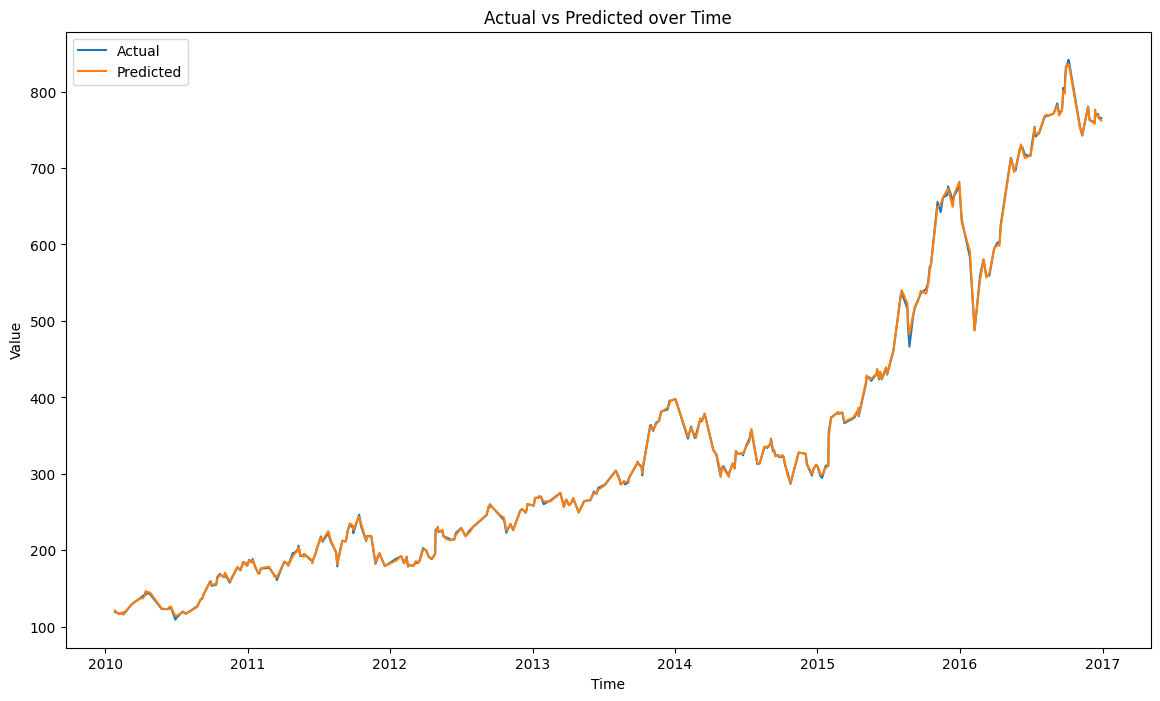

Leaderboard for AMZN:
                                            model_id      rmse       mse  \
0  StackedEnsemble_BestOfFamily_4_AutoML_4_202409...  2.436189  5.935019   
1  StackedEnsemble_BestOfFamily_3_AutoML_4_202409...  2.437933  5.943515   
2  GBM_lr_annealing_selection_AutoML_4_20240905_9...  2.523236  6.366719   
3        GBM_grid_1_AutoML_4_20240905_94944_model_26  2.531391  6.407940   
4  StackedEnsemble_AllModels_2_AutoML_4_20240905_...  2.532876  6.415461   

        mae     rmsle  mean_residual_deviance  
0  1.659437  0.007469                5.935019  
1  1.656703  0.006591                5.943515  
2  1.753127  0.008087                6.366719  
3  1.710786  0.007896                6.407940  
4  1.735666  0.007133                6.415461  
RMSE for AMZN: 2.4361894497170296



In [24]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()
for symbol in symbols_to_select:
    print(f"Processing symbol: {symbol}")
    result = train_and_evaluate_model(symbol, combined_df)

    results[symbol] = result

    print(f"Leaderboard for {symbol}:")
    print(result['leaderboard'].head())
    print(f"RMSE for {symbol}: {result['rmse']}\n")


In [25]:
for symbol, result in results.items():
    print(f"Results for {symbol}:")
    print("Leaderboard:")
    print(result['leaderboard'].head())
    print(f"RMSE: {result['rmse']}")
    print("-" * 30)


Results for AAPL:
Leaderboard:
                                            model_id      rmse       mse  \
0  StackedEnsemble_BestOfFamily_4_AutoML_1_202409...  0.482227  0.232543   
1  StackedEnsemble_AllModels_2_AutoML_1_20240905_...  0.482369  0.232680   
2  StackedEnsemble_AllModels_1_AutoML_1_20240905_...  0.482379  0.232689   
3  StackedEnsemble_BestOfFamily_2_AutoML_1_202409...  0.482398  0.232708   
4  StackedEnsemble_BestOfFamily_3_AutoML_1_202409...  0.482735  0.233034   

        mae     rmsle  mean_residual_deviance  
0  0.318615  0.005752                0.232543  
1  0.318805  0.005753                0.232680  
2  0.318838  0.005753                0.232689  
3  0.318912  0.005755                0.232708  
4  0.318804  0.005755                0.233034  
RMSE: 0.4822271570659028
------------------------------
Results for GOOGL:
Leaderboard:
                                            model_id      rmse       mse  \
0  StackedEnsemble_BestOfFamily_4_AutoML_2_202409...  2.3136

In [26]:
X = combined_df.drop(['close'], axis=1)
y = combined_df['close']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))
target_column = 'close'
time_column = 'date'

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [28]:

aml = H2OAutoML(max_runtime_secs=300,  # Adjust as needed
                   seed=1)
aml.train(x=list(X_train.columns),
          y=target_column,
          training_frame=train_h2o,
          leaderboard_frame=test_h2o,)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,103.0,103.0,1119482.0,10.0,10.0,10.0,15.0,818.0,465.28156
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2024-09-05 09:59:13,0.001 sec,0.0,75.1734974,37.7766293,5651.0547112,73.8695374,37.6264236,5456.7085515
,2024-09-05 09:59:14,1.195 sec,5.0,44.3939406,22.3091492,1970.8219580,43.6135270,22.2192223,1902.1397367
,2024-09-05 09:59:16,2.401 sec,10.0,26.2190171,13.1762329,687.4368552,25.7546278,13.1221668,663.3008533
,2024-09-05 09:59:17,3.642 sec,15.0,15.4871728,7.7835373,239.8525204,15.2061862,7.7507636,231.2280982
,2024-09-05 09:59:18,4.897 sec,20.0,9.1518073,4.6006187,83.7555760,8.9808337,4.5804988,80.6553744
,2024-09-05 09:59:19,5.999 sec,25.0,5.4139594,2.7230523,29.3109567,5.3110056,2.7110415,28.2067805
,2024-09-05 09:59:20,7.082 sec,30.0,3.2103735,1.6176193,10.3064979,3.1520798,1.6116455,9.9356070
,2024-09-05 09:59:21,8.170 sec,35.0,1.9164334,0.9698528,3.6727170,1.8936694,0.9696739,3.5859838


In [29]:
lb = aml.leaderboard
print(lb)
best_model = aml.leader
predictions = best_model.predict(test_h2o)
predictions_df = predictions.as_data_frame()

try:
    lb_df = aml.leaderboard.as_data_frame(use_multi_thread=True)
except ImportError:
    lb_df = aml.leaderboard.as_data_frame()

print(lb_df.head())
print(lb_df.columns)

model_id                                                    rmse       mse       mae         rmsle    mean_residual_deviance
GBM_4_AutoML_5_20240905_95507                           0.481126  0.231482  0.198099    0.00472037                  0.231482
StackedEnsemble_BestOfFamily_2_AutoML_5_20240905_95507  0.482215  0.232531  0.196645    0.00470519                  0.232531
GBM_3_AutoML_5_20240905_95507                           0.492811  0.242863  0.220719    0.00544295                  0.242863
StackedEnsemble_AllModels_1_AutoML_5_20240905_95507     0.510851  0.260968  0.195217    0.00508497                  0.260968
GBM_2_AutoML_5_20240905_95507                           0.516173  0.266435  0.238972    0.00607395                  0.266435
DRF_1_AutoML_5_20240905_95507                           0.694338  0.482106  0.245946    0.00604287                  0.482106
StackedEnsemble_BestOfFamily_1_AutoML_5_20240905_95507  0.79563   0.633027  0.225213    0.00850842                  0.633027


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


██████████████████████████████████████████████████████████| (done) 100%
                                            model_id      rmse       mse  \
0                      GBM_4_AutoML_5_20240905_95507  0.481126  0.231482   
1  StackedEnsemble_BestOfFamily_2_AutoML_5_202409...  0.482215  0.232531   
2                      GBM_3_AutoML_5_20240905_95507  0.492811  0.242863   
3  StackedEnsemble_AllModels_1_AutoML_5_20240905_...  0.510851  0.260968   
4                      GBM_2_AutoML_5_20240905_95507  0.516173  0.266435   

        mae     rmsle  mean_residual_deviance  
0  0.198099  0.004720                0.231482  
1  0.196645  0.004705                0.232531  
2  0.220719  0.005443                0.242863  
3  0.195217  0.005085                0.260968  
4  0.238972  0.006074                0.266435  
Index(['model_id', 'rmse', 'mse', 'mae', 'rmsle', 'mean_residual_deviance'], dtype='object')


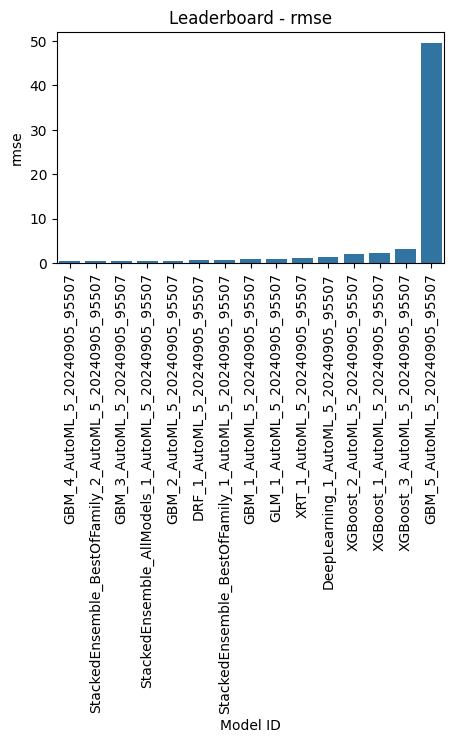

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the metric column to one of the existing columns
metric_column = 'rmse'  # You can change this to 'mse', 'mae', 'rmsle', etc.

# Plot the leaderboard
plt.figure(figsize=(5, 3))
sns.barplot(x='model_id', y=metric_column, data=lb_df)
plt.xticks(rotation=90)
plt.title(f'Leaderboard - {metric_column}')
plt.xlabel('Model ID')
plt.ylabel(metric_column)
plt.show()


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


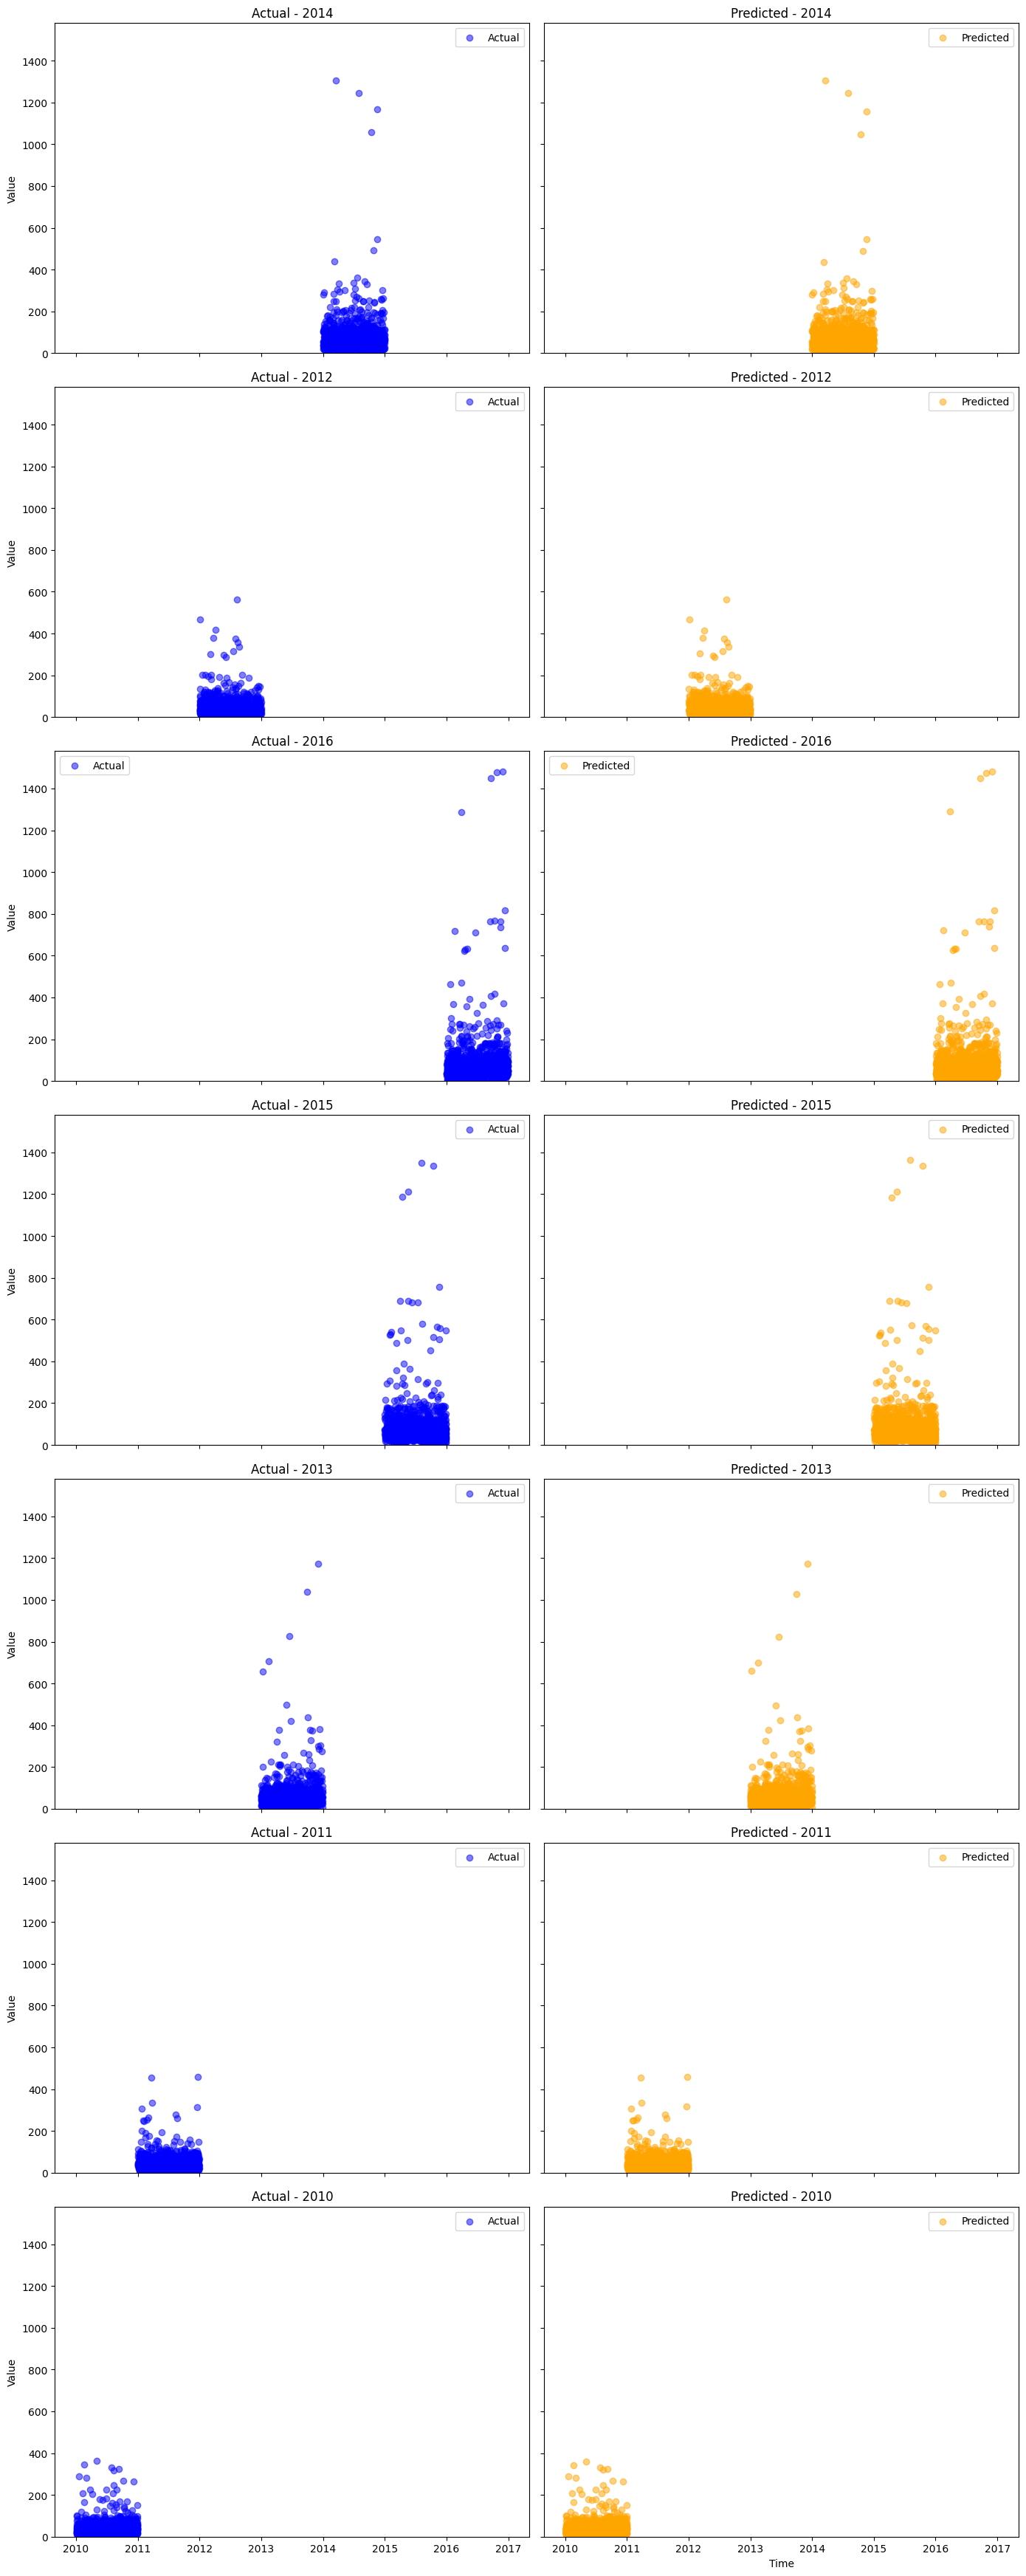

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert H2OFrames to Pandas DataFrames
time_series = test_h2o[time_column].as_data_frame()
actual_values = test_h2o[target_column].as_data_frame()

# Convert time column from milliseconds to datetime
time_series[time_column] = pd.to_datetime(time_series[time_column], unit='ms')

# Combine the data into a single DataFrame for easier sorting
df = pd.concat([time_series, actual_values, predictions_df['predict']], axis=1)
df.columns = [time_column, 'Actual', 'Predicted']

# Sort by time column to ensure the plot is in chronological order
df = df.sort_values(by=time_column)

# Extract the year from the datetime column
df['Year'] = df[time_column].dt.year

# Aggressively downsample the data for better visibility
df = df.sample(frac=0.05, random_state=42)

# Get the unique years in the dataset
years = df['Year'].unique()

# Create subplots - one for each year, separating actual and predicted plots
fig, axes = plt.subplots(len(years), 2, figsize=(14, 5 * len(years)), sharex=True, sharey=True)

# Plot each year separately
for i, year in enumerate(years):
    # Filter data for the current year
    df_year = df[df['Year'] == year]

    # Scatter plot for actual values
    axes[i, 0].scatter(df_year[time_column], df_year['Actual'], label='Actual', color='blue', alpha=0.5)
    axes[i, 0].set_title(f'Actual - {year}')
    axes[i, 0].set_ylabel('Value')

    # Scatter plot for predicted values
    axes[i, 1].scatter(df_year[time_column], df_year['Predicted'], label='Predicted', color='orange', alpha=0.5)
    axes[i, 1].set_title(f'Predicted - {year}')

    # Add legend
    axes[i, 0].legend()
    axes[i, 1].legend()

    # Optionally set y-axis limits (modify as needed)
    axes[i, 0].set_ylim([0, df['Actual'].max() + 100])

# Set common labels
plt.xlabel('Time')
plt.tight_layout()

# Show plot
plt.show()


In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error  # Import for RMSE calculation

# Filter the DataFrame for a specific symbol (e.g., 'AMZN') and drop unnecessary columns
symbol_df = combined_df[combined_df['symbol'] == 'AMZN'].drop(columns=['symbol'])

# Drop the 'date' column since it’s not needed for the LSTM model
df = symbol_df.drop(columns=['date'])

# Normalize the DataFrame using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler = MinMaxScaler(feature_range=(0, 1))  # Scaler for 'close' column only
scaled_df = scaler.fit_transform(df)

# Scale the 'close' column separately for proper inverse transformation later
df['close'] = close_scaler.fit_transform(df[['close']])

# Convert back to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

# Prepare the data for LSTM
close_index = scaled_df.columns.get_loc("close")
sequence_length = 100  # Use the past 100 days to predict the next day
X, y = [], []

for i in range(sequence_length, len(scaled_df)):
    X.append(scaled_df.iloc[i-sequence_length:i].values)
    y.append(scaled_df.iloc[i, close_index])

# Convert lists to numpy arrays after the loop
X = np.array(X)
y = np.array(y)

# Define the hyperparameter grid
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [8, 16, 32],
    'epochs': [50, 100],
    'learning_rate': [0.001, 0.01]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# To store the best score and the corresponding hyperparameters
best_score = float('inf')
best_params = {}

# Grid search for hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                for learning_rate in param_grid['learning_rate']:
                    print(f"Training with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}")

                    # Build the model
                    model = Sequential()
                    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
                    model.add(Dropout(dropout_rate))
                    model.add(LSTM(units=units, return_sequences=False))
                    model.add(Dropout(dropout_rate))
                    model.add(Dense(units=1))

                    # Compile the model
                    optimizer = Adam(learning_rate=learning_rate)
                    model.compile(optimizer=optimizer, loss='mean_squared_error')

                    # Train the model
                    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

                    # Evaluate the model
                    score = model.evaluate(X_test, y_test, verbose=0)
                    print(f"Validation loss: {score}")

                    # If this score is better, update best_score and best_params
                    if score < best_score:
                        best_score = score
                        best_params = {
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'learning_rate': learning_rate
                        }

# Output the best parameters and validation loss
print(f"Best Validation Loss: {best_score}")
print(f"Best Hyperparameters: {best_params}")


Training with units=50, dropout_rate=0.2, batch_size=8, epochs=50, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.00017321704945061356
Training with units=50, dropout_rate=0.2, batch_size=8, epochs=50, learning_rate=0.01
Validation loss: 0.0006277533248066902
Training with units=50, dropout_rate=0.2, batch_size=8, epochs=100, learning_rate=0.001
Validation loss: 0.00016050130943767726
Training with units=50, dropout_rate=0.2, batch_size=8, epochs=100, learning_rate=0.01
Validation loss: 0.00030407586018554866
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.001
Validation loss: 0.00025659624952822924
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.01
Validation loss: 0.0007426443626172841
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.001
Validation loss: 0.00048790316213853657
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.01
Validation loss: 0.00026967652956955135
Training with units=50, dropout_rate=0.2, batch_size=32, epochs=50, l

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Filter the DataFrame for a specific symbol (e.g., 'AMZN') and drop unnecessary columns
symbol_df = combined_df[combined_df['symbol'] == 'AMZN'].drop(columns=['symbol'])

# Drop the 'date' column since it’s not needed for the RNN model
df = symbol_df.drop(columns=['date'])

# Normalize the DataFrame using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler = MinMaxScaler(feature_range=(0, 1))  # Scaler for 'close' column only
scaled_df = scaler.fit_transform(df)

# Scale the 'close' column separately for proper inverse transformation later
df['close'] = close_scaler.fit_transform(df[['close']])

# Convert back to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

# Prepare the data for RNN
close_index = scaled_df.columns.get_loc("close")
sequence_length = 100  # Use the past 100 days to predict the next day
X, y = [], []

for i in range(sequence_length, len(scaled_df)):
    X.append(scaled_df.iloc[i-sequence_length:i].values)
    y.append(scaled_df.iloc[i, close_index])

# Convert lists to numpy arrays after the loop
X = np.array(X)
y = np.array(y)

# Define the hyperparameter grid
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [8, 16, 32],
    'epochs': [50, 100],
    'learning_rate': [0.001, 0.01]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# To store the best score and the corresponding hyperparameters
best_score = float('inf')
best_params = {}

# Grid search for hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                for learning_rate in param_grid['learning_rate']:
                    print(f"Training with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}")

                    # Build the RNN model
                    model = Sequential()
                    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
                    model.add(Dropout(dropout_rate))
                    model.add(SimpleRNN(units=units, return_sequences=False))
                    model.add(Dropout(dropout_rate))
                    model.add(Dense(units=1))

                    # Compile the model
                    optimizer = Adam(learning_rate=learning_rate)
                    model.compile(optimizer=optimizer, loss='mean_squared_error')

                    # Train the model
                    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

                    # Evaluate the model
                    score = model.evaluate(X_test, y_test, verbose=0)
                    print(f"Validation loss: {score}")

                    # If this score is better, update best_score and best_params
                    if score < best_score:
                        best_score = score
                        best_params = {
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'learning_rate': learning_rate
                        }

# Output the best parameters and validation loss
print(f"Best Validation Loss: {best_score}")
print(f"Best Hyperparameters: {best_params}")


Training with units=50, dropout_rate=0.2, batch_size=8, epochs=50, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.00034626753767952323
Training with units=50, dropout_rate=0.2, batch_size=8, epochs=50, learning_rate=0.01
Validation loss: 0.016536930575966835
Training with units=50, dropout_rate=0.2, batch_size=8, epochs=100, learning_rate=0.001
Validation loss: 0.0011954618385061622
Training with units=50, dropout_rate=0.2, batch_size=8, epochs=100, learning_rate=0.01
Validation loss: 0.008498313836753368
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.001
Validation loss: 0.00032403419027104974
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.01
Validation loss: 0.00037873032852075994
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.001
Validation loss: 0.00035519793163985014
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.01
Validation loss: 0.0019750429783016443
Training with units=50, dropout_rate=0.2, batch_size=32, epochs=50, learn

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout, Input  # Added Input layer
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Import for RMSE, MAE calculation


# Initialize a dictionary to store results for each symbol
results = {}

def preprocess_data(symbol, combined_df):
    """
    Function to Preprocess the data for the given symbol.
    """
    # Filter the DataFrame to include only rows with the specified symbol
    symbol_df = combined_df[combined_df['symbol'] == symbol].drop(columns=['symbol'])

    # Drop the 'date' column since it’s not needed for the LSTM model
    df = symbol_df.drop(columns=['date'])

    # Normalize the DataFrame using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_scaler = MinMaxScaler(feature_range=(0, 1))  # Scaler for 'close' column only
    scaled_df = scaler.fit_transform(df)

    # Scale the 'close' column separately for proper inverse transformation later
    df['close'] = close_scaler.fit_transform(df[['close']])

    # Convert back to DataFrame for easier handling
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

    # Prepare the data for LSTM
    close_index = scaled_df.columns.get_loc("close")
    sequence_length = 100  # Use the past 100 days to predict the next day
    X, y = [], []

    for i in range(sequence_length, len(scaled_df)):
        X.append(scaled_df.iloc[i-sequence_length:i].values)
        y.append(scaled_df.iloc[i, close_index])

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler, close_scaler

def lstm(X_train, y_train, X_test, y_test):
    """
    Function to Train LSTM model with the given data.
    """
    # Initialize the LSTM model
    model = Sequential()

    # Add Input layer and LSTM layers with dropout to prevent overfitting
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Define input shape using Input layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.3))

    # Add a Dense layer to output the close price prediction
    model.add(Dense(units=1))  # Only one output for the close price

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')

    return model, test_loss

def rnn(X_train, y_train, X_test, y_test):
    """
    Function to Train RNN model with the given data.
    """
    # Initialize the RNN model
    model = Sequential()

    # Add Input layer and SimpleRNN layers with dropout to prevent overfitting
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Define input shape using Input layer
    model.add(SimpleRNN(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(SimpleRNN(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Add a Dense layer to output the close price prediction
    model.add(Dense(units=1))  # Only one output for the close price

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')

    return model, test_loss

def calculate_metrics(y_true, y_pred):
    """
    Calculate evaluation metrics: MSE, RMSE, MAPE, and MAE.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    return mse, rmse, mae, mape

def predict(model_function):
    """
    Predict stock prices using the given model function (either lstm or rnn).
    """
    # Loop through each symbol
    for symbol in symbols_to_select:
        print(f"\nProcessing symbol: {symbol}")

        # Preprocess data for the current symbol
        X, y, scaler, close_scaler = preprocess_data(symbol, combined_df)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train the model using the provided model function (lstm or rnn)
        model, test_loss = model_function(X_train, y_train, X_test, y_test)

        # Predict on the test set
        predicted = model.predict(X_test)

        # Inverse transform to get the actual price scale for the 'close' column only
        predicted_actual = close_scaler.inverse_transform(predicted)
        y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculate MSE, RMSE, MAE, MAPE
        mse, rmse, mae, mape = calculate_metrics(y_test_actual, predicted_actual)
        print(f'MSE for {symbol}: {mse}')
        print(f'RMSE for {symbol}: {rmse}')
        print(f'MAE for {symbol}: {mae}')
        print(f'MAPE for {symbol}: {mape}')

        # Store the results
        results[symbol] = {'model': model, 'test_loss': test_loss, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}

        # Plot the actual vs predicted values
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_actual, color='black', label='Actual Close Price')
        plt.plot(predicted_actual, color='green', label='Predicted Close Price')
        plt.title(f'Stock Price Prediction for {symbol}')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    # Display summary results
    for symbol, result in results.items():
        print(f"Symbol: {symbol}, Test Loss: {result['test_loss']}, MSE: {result['mse']}, RMSE: {result['rmse']}, MAE: {result['mae']}, MAPE: {result['mape']}")




Processing symbol: AAPL
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.9500e-04
Test Loss: 0.0002941345446743071
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
MSE for AAPL: 3.2777809639080258
RMSE for AAPL: 1.8104642951210128
MAE for AAPL: 1.3939918970670795
MAPE for AAPL: 1.8415956734680832


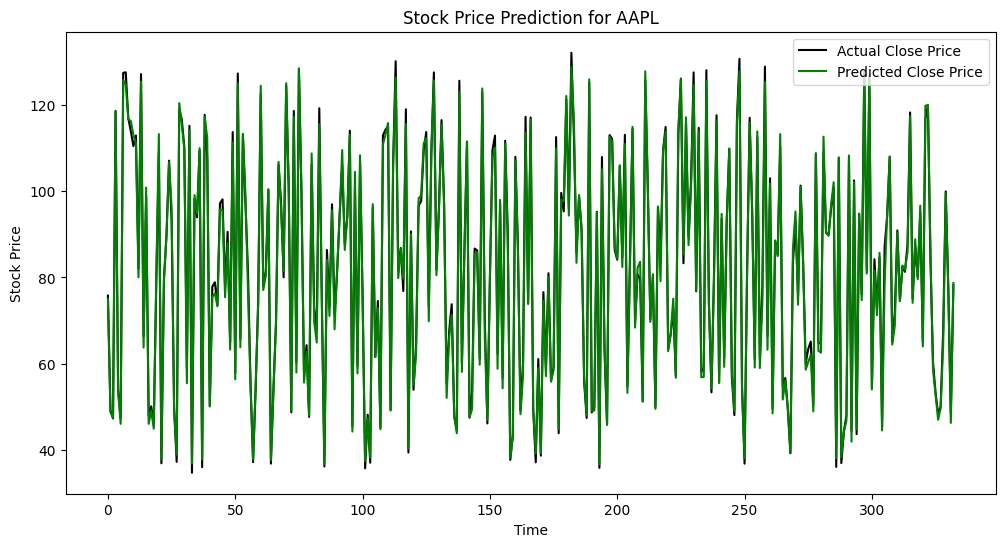


Processing symbol: GOOGL
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.2012e-04
Test Loss: 0.000529019976966083
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
MSE for GOOGL: 201.7099262813049
RMSE for GOOGL: 14.202461979576107
MAE for GOOGL: 11.393479574170023
MAPE for GOOGL: 2.9460206617563713


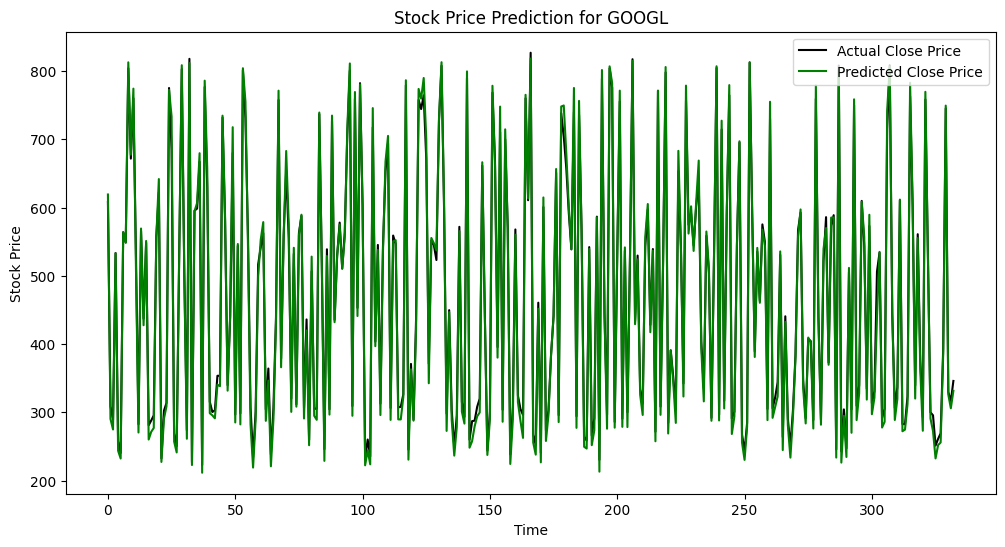


Processing symbol: MSFT
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0959e-04
Test Loss: 0.0005243811174295843
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
MSE for MSFT: 0.8647953227045062
RMSE for MSFT: 0.9299437201812302
MAE for MSFT: 0.6940937384183501
MAPE for MSFT: 1.7657560488555955


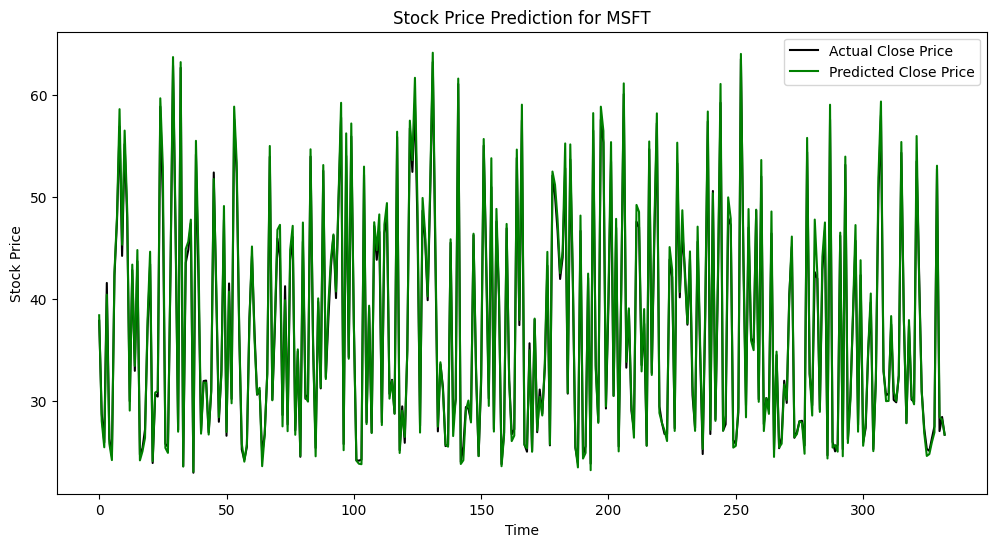


Processing symbol: AMZN
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.7541e-04
Test Loss: 0.00016920275811571628
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
MSE for AMZN: 91.59419117820697
RMSE for AMZN: 9.570485420197189
MAE for AMZN: 7.252900761251003
MAPE for AMZN: 2.3296491312414926


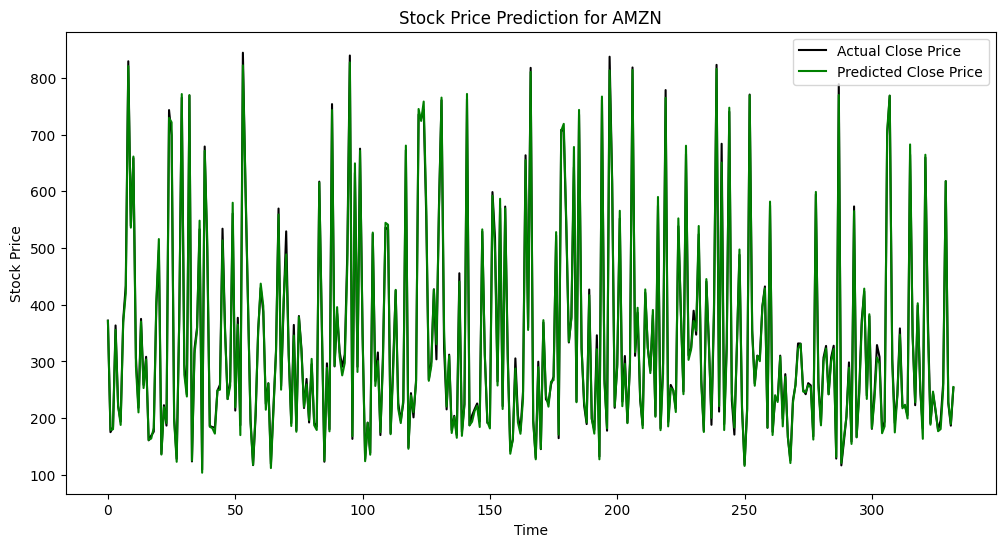

Symbol: AAPL, Test Loss: 0.0002941345446743071, MSE: 3.2777809639080258, RMSE: 1.8104642951210128, MAE: 1.3939918970670795, MAPE: 1.8415956734680832
Symbol: GOOGL, Test Loss: 0.000529019976966083, MSE: 201.7099262813049, RMSE: 14.202461979576107, MAE: 11.393479574170023, MAPE: 2.9460206617563713
Symbol: MSFT, Test Loss: 0.0005243811174295843, MSE: 0.8647953227045062, RMSE: 0.9299437201812302, MAE: 0.6940937384183501, MAPE: 1.7657560488555955
Symbol: AMZN, Test Loss: 0.00016920275811571628, MSE: 91.59419117820697, RMSE: 9.570485420197189, MAE: 7.252900761251003, MAPE: 2.3296491312414926


In [14]:
predict(rnn)


Processing symbol: AAPL
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1337e-04 
Test Loss: 0.0004050431016366929
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE for AAPL: 4.513725170066699
RMSE for AAPL: 2.1245529341644325
MAE for AAPL: 1.727518273976518
MAPE for AAPL: 2.418882735398308


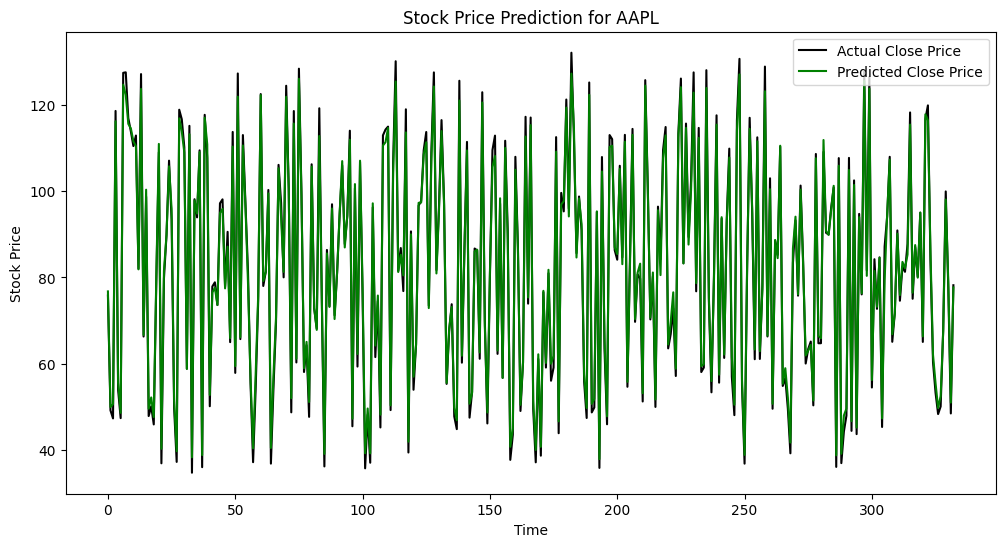


Processing symbol: GOOGL
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7409e-04 
Test Loss: 0.0007064270321279764
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE for GOOGL: 269.35333438601043
RMSE for GOOGL: 16.411987520894915
MAE for GOOGL: 13.241126628198737
MAPE for GOOGL: 2.930275952768444


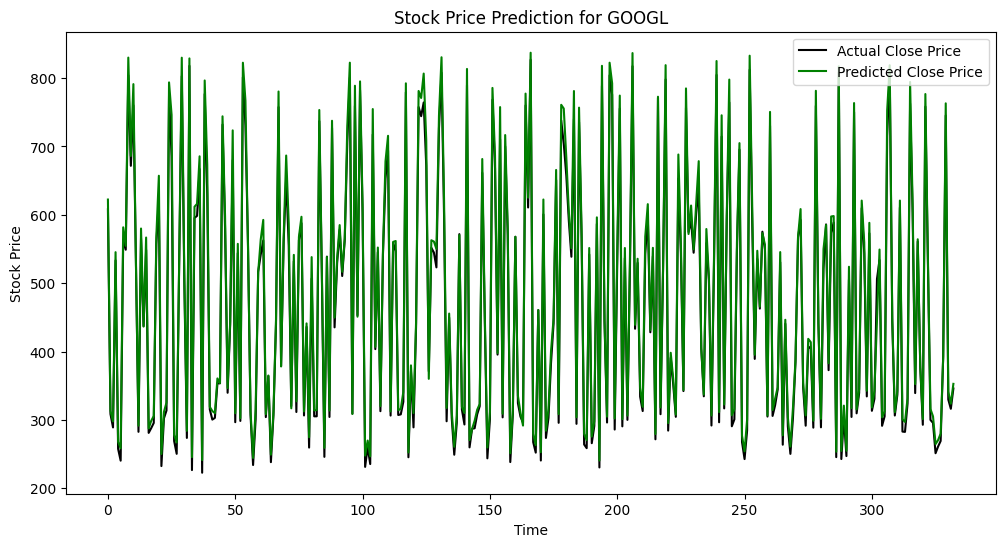


Processing symbol: MSFT
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5929e-04 
Test Loss: 0.000811674864962697
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE for MSFT: 1.3385908718326438
RMSE for MSFT: 1.1569748795166832
MAE for MSFT: 0.9029941462853234
MAPE for MSFT: 2.3653838876803865


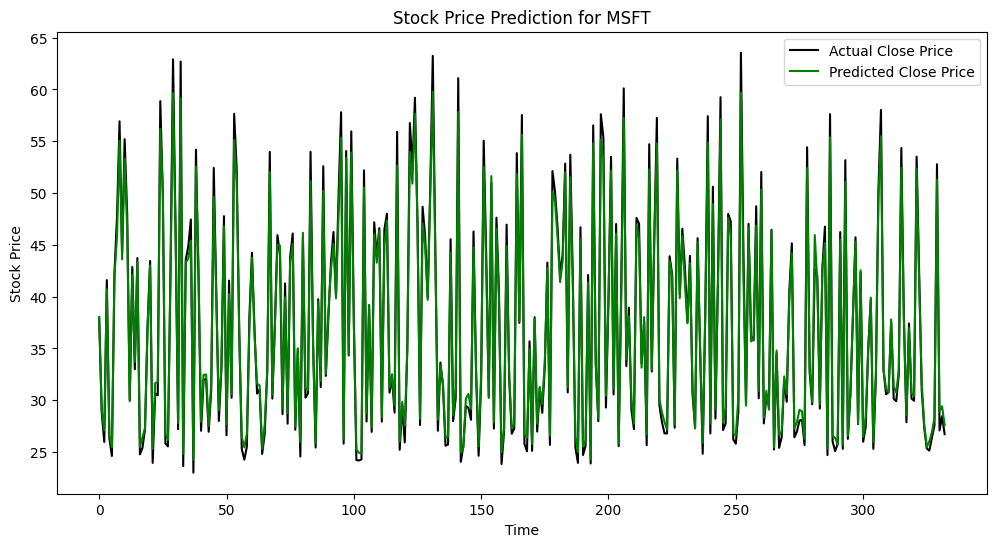


Processing symbol: AMZN
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1137e-04 
Test Loss: 0.00038818750181235373
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE for AMZN: 210.13688170798213
RMSE for AMZN: 14.496098844447154
MAE for AMZN: 9.774920097650385
MAPE for AMZN: 2.548373815125659


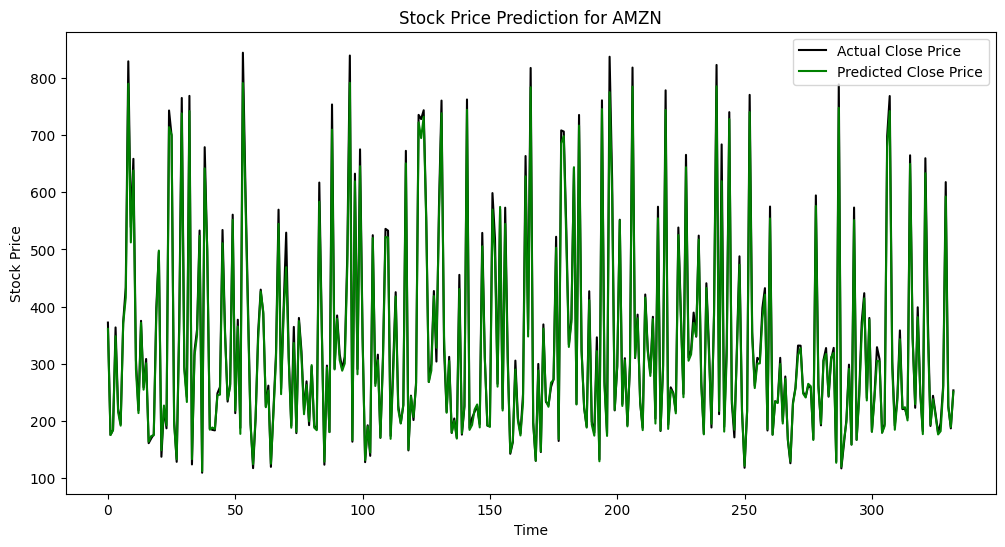

Symbol: AAPL, Test Loss: 0.0004050431016366929, MSE: 4.513725170066699, RMSE: 2.1245529341644325, MAE: 1.727518273976518, MAPE: 2.418882735398308
Symbol: GOOGL, Test Loss: 0.0007064270321279764, MSE: 269.35333438601043, RMSE: 16.411987520894915, MAE: 13.241126628198737, MAPE: 2.930275952768444
Symbol: MSFT, Test Loss: 0.000811674864962697, MSE: 1.3385908718326438, RMSE: 1.1569748795166832, MAE: 0.9029941462853234, MAPE: 2.3653838876803865
Symbol: AMZN, Test Loss: 0.00038818750181235373, MSE: 210.13688170798213, RMSE: 14.496098844447154, MAE: 9.774920097650385, MAPE: 2.548373815125659


In [15]:
predict(lstm)